In [149]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [150]:
fetcher = DataFetcher(
    db_params=DB_PARAMS,
    reports_table="reports_2",
    targets_table="targets_yf",
)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [151]:
df = fetcher.fetch_data(
    regressors=[
    'hv_orig_score', 
    "md_hv1", 
    "md_hv2", 
    'md_hv3', 
    'lm_orig_score', 
    'md_lm1', 
    'md_lm2', 
    'md_lm3',
    'eps_surprise',
    'f_size',
    'doc_len'
    
    ],
    prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:130: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:161: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:169: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [152]:
df.isna().sum()

report_type          0
hv_orig_score        0
md_hv1               0
md_hv2               0
md_hv3               0
lm_orig_score        0
md_lm1               0
md_lm2               0
md_lm3               0
eps_surprise         0
f_size               0
doc_len              0
two_day_r           15
three_day_r          0
four_day_r           0
five_day_r           0
six_day_r            0
seven_day_r          0
full_q_r             0
two_day_e_r         15
three_day_e_r        0
four_day_e_r         0
five_day_e_r         0
six_day_e_r          0
seven_day_e_r        0
full_q_e_r           0
two_day_abn_r        0
three_day_abn_r      0
four_day_abn_r       0
five_day_abn_r       0
six_day_abn_r        0
seven_day_abn_r      0
full_q_abn_r         0
two_day_r_vol      177
three_day_r_vol    177
four_day_r_vol     177
five_day_r_vol     177
six_day_r_vol      177
seven_day_r_vol    177
full_q_r_vol       177
dtype: int64

In [153]:
df['f_size']

company  date  
A        2019.1    2.447506e+10
         2019.2    2.068122e+10
         2019.3    2.119690e+10
         2019.4    2.514862e+10
         2020.1    2.463511e+10
                       ...     
ZTS      2022.2    8.318959e+10
         2022.3    8.346320e+10
         2022.4    6.164240e+10
         2023.1    7.942337e+10
         2023.2    7.688532e+10
Name: f_size, Length: 8067, dtype: float64

In [154]:
df.columns

Index(['report_type', 'hv_orig_score', 'md_hv1', 'md_hv2', 'md_hv3',
       'lm_orig_score', 'md_lm1', 'md_lm2', 'md_lm3', 'eps_surprise', 'f_size',
       'doc_len', 'two_day_r', 'three_day_r', 'four_day_r', 'five_day_r',
       'six_day_r', 'seven_day_r', 'full_q_r', 'two_day_e_r', 'three_day_e_r',
       'four_day_e_r', 'five_day_e_r', 'six_day_e_r', 'seven_day_e_r',
       'full_q_e_r', 'two_day_abn_r', 'three_day_abn_r', 'four_day_abn_r',
       'five_day_abn_r', 'six_day_abn_r', 'seven_day_abn_r', 'full_q_abn_r',
       'two_day_r_vol', 'three_day_r_vol', 'four_day_r_vol', 'five_day_r_vol',
       'six_day_r_vol', 'seven_day_r_vol', 'full_q_r_vol'],
      dtype='object')

In [155]:
df.loc[('A')]['f_size']


date
2019.1    2.447506e+10
2019.2    2.068122e+10
2019.3    2.119690e+10
2019.4    2.514862e+10
2020.1    2.463511e+10
2020.2    2.647768e+10
2020.3    3.036903e+10
2020.4    3.577338e+10
2021.1    3.717432e+10
2021.2    4.142316e+10
2021.3    5.204434e+10
2021.4    4.465222e+10
2022.1    3.951995e+10
2022.2    3.797673e+10
2022.3    3.732478e+10
2022.4    4.364278e+10
2023.1    4.177745e+10
2023.2    3.516530e+10
2023.3    3.582901e+10
2023.4    4.070080e+10
Name: f_size, dtype: float64

In [ ]:
class FEModeler:
    """
    A class to run panel fixed effects regressions using PanelOLS
    and extract key parameter statistics for a specified regressor.

    Attributes:
        df: The input panel data.
        var_names: Column names of the input DataFrame.
        params_dict: Dictionary storing regression parameters for each independent variable.
    """

    def __init__(self, df: pd.DataFrame, scale: bool = False, scale_glob: bool = False):
        """
        Initialize the FEModeler with panel data.

        Args:
            df: Panel DataFrame with MultiIndex (entity, time).
            scale: Whether to standardize the regressors.
        """
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}
        self.scale = scale

        if scale:
            self._scale_regressors()   print(result_summary)
        elif scale_glob:
            self._scale_regressors_global_std()

    def _scale_regressors(self):
        """
        Standardize regressors: columns 1 to 8 (your x variables), plus control variables eps_surprise, f_size.
        Scaling is done entity-wise (within-entity).
        """
        x_cols = list(self.df.columns[1:9]) + ['eps_surprise', 'f_size']
        scaler = StandardScaler()

        # Scale within each entity group
        for entity in self.df.index.get_level_values(0).unique():
            entity_mask = self.df.index.get_level_values(0) == entity
            sub_df = self.df.loc[entity_mask, x_cols]
            if sub_df.shape[0] < 2:
                continue
            self.df.loc[entity_mask, x_cols] = scaler.fit_transform(sub_df)
    
    def _scale_regressors_global_std(self):
        """
        Divide each regressor column by its overall (global) standard deviation.
        No demeaning, no within-entity transformations.
        """
        x_cols = self.df.columns[1:9].tolist() + ['eps_surprise', 'f_size']

        # population s.d. (ddof=0).  Use ddof=1 if you prefer the sample s.d.
        scale_factors = self.df[x_cols].std(ddof=0)

        # save for later if you want to back-transform coefficients
        self.scale_factors_ = scale_factors

        # broadcast division
        self.df[x_cols] = self.df[x_cols] / scale_factors



    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        """
        Extract parameter statistics for a given regressor from the regression summary.

        Args:
            summary: The PanelOLS regression summary object.
            regressor_name: The name of the regressor to extract parameters for.

        Returns:
            A Series containing coefficient, std error, p-value, and confidence intervals.
        """
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        """
        Fit a fixed effects regression model using PanelOLS.

        Args:
            data: A subset of the full DataFrame containing required variables.
            formula: Regression formula in Patsy-style syntax.

        Returns:
            The regression summary object.
        """
        model = PanelOLS.from_formula(formula, data=data, check_rank=True)
        result = model.fit(cov_type='kernel',  bandwidth=4)
        return result.summary

    def compute(self) -> dict[str, list[pd.Series]]:
        """
        Run fixed effects regressions for all combinations of independent and dependent variables,
        and store the parameter summaries for each independent variable.

        Returns:
            A dictionary where keys are independent variable names,
            and values are lists of Series with parameter info for each dependent variable.
        """
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

        var_names = self.df.columns 

        for x in range(1, 9):
            # Targets starts from y index
            y = 12

            per_target_params = {}
            for target in targets:  
                if target not in per_target_params:
                    per_target_params[target] = {}

                for frame in time_frames:
                    print(self.df.columns[x], self.df.columns[y])

                    data = self.df.iloc[:, [x, 9, 10, 11, y]].dropna().copy()

                    formula = f"{var_names[y]} ~ {var_names[x]}  + f_size + eps_surprise + EntityEffects + TimeEffects"
                    try:
                        result_summary = self.fit(data, formula)
                        param_info = self.extract_params(result_summary, self.var_names[x])
                        per_target_params[target][self.df.columns[y]] = param_info
                        
                    except Exception as e:
                        print(e)
                    y += 1

            self.params_dict[self.df.columns[x]] = per_target_params

        return self.params_dict
    
    def plot_all_params(self):
        """
        Plot bar charts for each regressor–target combination.
        Each chart shows 7 timeframes with confidence intervals.
        """
        for regressor, target_dict in self.params_dict.items():
            for target, outcomes in target_dict.items():
                keys = list(outcomes.keys())
                if len(keys) < 1:
                    continue

                x = np.arange(len(keys))
                params = [outcomes[k]['Parameter'] for k in keys]
                lower = [outcomes[k]['Lower CI'] for k in keys]
                upper = [outcomes[k]['Upper CI'] for k in keys]

                plt.figure(figsize=(8, 6))
                plt.bar(x, params, width=0.4, color='tab:blue', label=regressor)

                # Confidence intervals
                for i in range(len(keys)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color='black', linewidth=1.5)

                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, keys, rotation=45)
                plt.title(f"{regressor} on {target}")
                plt.xlabel('Time frame')
                plt.ylabel('Beta coefficient')
                plt.tight_layout()

                ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
                plt.legend(handles=[ci_legend])
                plt.show()

    def graph_3d(self):
        """
        Plot one 3D chart per regressor with beta bars across:
        - X: timeframes
        - Y: targets (sorted by |first beta| descending)
        - Z: beta value
        Includes confidence interval   print(result_summary)s and colors by target.
        """
        timeframes = ['two_day', 'three_day', 'four_day', 'five_day', 'six_day', 'seven_day', 'full_q']
        tf_labels = ['2d', '3d', '4d', '5d', '6d', '7d', 'fq']
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        suffixes = {'returns': 'r', 'e_returns': 'e_r', 'abn_returns': 'abn_r', 'r_vol': 'r_vol'}
        for regressor, target_dict in self.params_dict.items():
            fig = plt.figure(figsize=(8, 12))
            ax = fig.add_subplot(111, projection='3d')
            # --- Sort targets by abs(first_beta) ---
            sort_metric = {}
            for target in targets:
                suffix = suffixes[target]
                key = f"{timeframes[0]}_{suffix}"
                try:
                    sort_metric[target] = target_dict[target][key]['Parameter']
                except KeyError:
                    sort_metric[target] = -np.inf  # push missing to the front
            sorted_targets = sorted(targets, key=lambda t: sort_metric[t])  # high to low
            # Positions
            n_targets = len(targets)
            n_frames = len(timeframes)
            x_pos, y_pos = np.meshgrid(np.arange(n_frames), np.arange(n_targets))
            x_pos = x_pos.flatten()
            y_pos = y_pos.flatten()
            z_pos = np.zeros_like(x_pos)
            dx = dy = 0.4
            # Collect values
            dz, ci_l, ci_u = [], [], []
            for target in sorted_targets:
                suffix = suffixes[target]
                for tf in timeframes:
                    key = f"{tf}_{suffix}"
                    try:
                        series = target_dict[target][key]
                        dz.append(series['Parameter'])
                        ci_l.append(series['Lower CI'])
                        ci_u.append(series['Upper CI'])
                    except KeyError:
                        dz.append(0)
                        ci_l.append(0)
                        ci_u.append(0)
            dz = np.array(dz)
            ci_l = np.array(ci_l)
            ci_u = np.array(ci_u)
            # Colors per target
            color_map = plt.colormaps.get_cmap('tab10')
            bar_colors = []
            for i in range(n_targets):
                bar_colors.extend([color_map(i / n_targets)] * n_frames)
            # Draw bars
            ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, alpha=0.6, shade=True)
            # Draw confidence interval lines
            for i, (x, y, z, low, high) in enumerate(zip(x_pos, y_pos, dz, ci_l, ci_u)):
                ax.plot([x + dx / 2, x + dx / 2], [y + dy / 2, y + dy / 2], [low, high],
                        color='black', linewidth=1.5, zorder=10)
            # Axes setup
            ax.set_xlabel('Timeframe')
            ax.set_ylabel('Target', labelpad=15)
            ax.set_zlabel('')  # remove default
            z_max = np.nanmax(ci_u)

# Place the label directly at the Z-axis tip visually
            ax.text(x=0, y=-2.0, z=z_max + 0.02,
                    s='Beta', fontsize=13, ha='center', va='bottom',
                    rotation=0, weight='bold', zorder=1000)

            #fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

            ax.set_xticks(np.arange(n_frames) + dx / 2)
            ax.set_xticklabels(tf_labels)
            ax.set_yticks(np.arange(n_targets) + dy / 2)
            ax.set_yticklabels(sorted_targets)
            ax.set_title(f"3D Coefficients for Regressor: {regressor}")
            plt.tight_layout()
            plt.show()

In [157]:
df

report_type  hv_orig_score    md_hv1    md_hv2    md_hv3  \
company date                                                              
A       2019.1        10-Q       0.327818  0.412048  0.463092  0.144105   
        2019.2        10-Q       0.318681  0.416058  0.453348  0.127967   
        2019.3        10-Q       0.338225  0.424395  0.457195  0.145952   
        2019.4        10-K       0.400181  0.425304  0.464432  0.146274   
        2020.1        10-Q       0.369223  0.415193  0.477226  0.121194   
...                    ...            ...       ...       ...       ...   
ZTS     2022.2        10-Q       0.425630  0.389347  0.418911  0.101604   
        2022.3        10-Q       0.412292  0.406380  0.436782  0.106592   
        2022.4        10-Q       0.406832  0.402945  0.427981  0.108857   
        2023.1        10-K       0.439736  0.385651  0.460024  0.138981   
        2023.2        10-Q       0.463665  0.408567  0.420854  0.092608   

                lm_orig_score    md_lm1    md_lm2    md_lm3  eps_surprise  \
company date                                                                
A       2019.1      -0.468391 -0.025729 -0.449024 -0.641541        0.0402   
        2019.2      -0.453815 -0.048077 -0.447552 -0.646677        0.1007   
        2019.3      -0.445783 -0.033708 -0.445215 -0.661836        0.0681   
        2019.4      -0.400521  0.051303 -0.409195 -0.652946        0.0119   
        2020.1      -0.505988 -0.049161 -0.442901 -0.656453        0.1379   
...                       ...       ...       ...       ...           ...   
ZTS     2022.2      -0.707921 -0.059844 -0.323251 -0.583618        0.2500   
        2022.3      -0.690205 -0.066086 -0.307759 -0.572581        0.1316   
        2022.4      -0.682203 -0.054340 -0.288221 -0.567780        0.1233   
        2023.1      -0.578481  0.032762 -0.370798 -0.592050        0.1159   
        2023.2      -0.550173 -0.035294 -0.330604 -0.562897        0.1081   

                ...  six_day_abn_r  seven_day_abn_r  full_q_abn_r  \
company date    ...                                                 
A       2019.1  ...      -0.134644        -0.171501     -0.283860   
        2019.2  ...       0.268275         0.164856      0.029067   
        2019.3  ...       0.546652         0.564545      0.117120   
        2019.4  ...       0.032633         0.051254     -0.008724   
        2020.1  ...      -0.513019        -0.561452      0.139778   
...             ...            ...              ...           ...   
ZTS     2022.2  ...      -0.065109        -0.217090     -0.010812   
        2022.3  ...      -0.792869        -0.715688     -0.291245   
        2022.4  ...      -1.202917        -0.658716      0.077379   
        2023.1  ...       0.985898         1.036463      0.159671   
        2023.2  ...       0.545574         0.396375     -0.005126   

                two_day_r_vol  three_day_r_vol  four_day_r_vol  \
company date                                                     
A       2019.1       0.131182         0.096568        0.088686   
        2019.2       0.060121         0.067283        0.076504   
        2019.3       0.079536         0.095590        0.096590   
        2019.4       0.063094         0.054265        0.050310   
        2020.1       0.258392         0.257832        0.236403   
...                       ...              ...             ...   
ZTS     2022.2       0.142569         0.142729        0.154875   
        2022.3       0.125953         0.116657        0.116078   
        2022.4       0.363517         0.335023        0.316788   
        2023.1       0.230088         0.175101        0.162249   
        2023.2       0.273621         0.246584        0.226731   

                five_day_r_vol  six_day_r_vol  seven_day_r_vol  full_q_r_vol  
company date                                                                  
A       2019.1        0.088205       0.084073         0.081526      0.120923  
        2019.2        0.080681       0.0804

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8067 entries, ('A', 2019.1) to ('ZTS', 2023.2)
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   report_type      8067 non-null   object 
 1   hv_orig_score    8067 non-null   float64
 2   md_hv1           8067 non-null   float64
 3   md_hv2           8067 non-null   float64
 4   md_hv3           8067 non-null   float64
 5   lm_orig_score    8067 non-null   float64
 6   md_lm1           8067 non-null   float64
 7   md_lm2           8067 non-null   float64
 8   md_lm3           8067 non-null   float64
 9   eps_surprise     8067 non-null   float64
 10  f_size           8067 non-null   float64
 11  doc_len          8067 non-null   int64  
 12  two_day_r        8052 non-null   float64
 13  three_day_r      8067 non-null   float64
 14  four_day_r       8067 non-null   float64
 15  five_day_r       8067 non-null   float64
 16  six_day_r        8067 non-null   floa

In [159]:
df

report_type  hv_orig_score    md_hv1    md_hv2    md_hv3  \
company date                                                              
A       2019.1        10-Q       0.327818  0.412048  0.463092  0.144105   
        2019.2        10-Q       0.318681  0.416058  0.453348  0.127967   
        2019.3        10-Q       0.338225  0.424395  0.457195  0.145952   
        2019.4        10-K       0.400181  0.425304  0.464432  0.146274   
        2020.1        10-Q       0.369223  0.415193  0.477226  0.121194   
...                    ...            ...       ...       ...       ...   
ZTS     2022.2        10-Q       0.425630  0.389347  0.418911  0.101604   
        2022.3        10-Q       0.412292  0.406380  0.436782  0.106592   
        2022.4        10-Q       0.406832  0.402945  0.427981  0.108857   
        2023.1        10-K       0.439736  0.385651  0.460024  0.138981   
        2023.2        10-Q       0.463665  0.408567  0.420854  0.092608   

                lm_orig_score    md_lm1    md_lm2    md_lm3  eps_surprise  \
company date                                                                
A       2019.1      -0.468391 -0.025729 -0.449024 -0.641541        0.0402   
        2019.2      -0.453815 -0.048077 -0.447552 -0.646677        0.1007   
        2019.3      -0.445783 -0.033708 -0.445215 -0.661836        0.0681   
        2019.4      -0.400521  0.051303 -0.409195 -0.652946        0.0119   
        2020.1      -0.505988 -0.049161 -0.442901 -0.656453        0.1379   
...                       ...       ...       ...       ...           ...   
ZTS     2022.2      -0.707921 -0.059844 -0.323251 -0.583618        0.2500   
        2022.3      -0.690205 -0.066086 -0.307759 -0.572581        0.1316   
        2022.4      -0.682203 -0.054340 -0.288221 -0.567780        0.1233   
        2023.1      -0.578481  0.032762 -0.370798 -0.592050        0.1159   
        2023.2      -0.550173 -0.035294 -0.330604 -0.562897        0.1081   

                ...  six_day_abn_r  seven_day_abn_r  full_q_abn_r  \
company date    ...                                                 
A       2019.1  ...      -0.134644        -0.171501     -0.283860   
        2019.2  ...       0.268275         0.164856      0.029067   
        2019.3  ...       0.546652         0.564545      0.117120   
        2019.4  ...       0.032633         0.051254     -0.008724   
        2020.1  ...      -0.513019        -0.561452      0.139778   
...             ...            ...              ...           ...   
ZTS     2022.2  ...      -0.065109        -0.217090     -0.010812   
        2022.3  ...      -0.792869        -0.715688     -0.291245   
        2022.4  ...      -1.202917        -0.658716      0.077379   
        2023.1  ...       0.985898         1.036463      0.159671   
        2023.2  ...       0.545574         0.396375     -0.005126   

                two_day_r_vol  three_day_r_vol  four_day_r_vol  \
company date                                                     
A       2019.1       0.131182         0.096568        0.088686   
        2019.2       0.060121         0.067283        0.076504   
        2019.3       0.079536         0.095590        0.096590   
        2019.4       0.063094         0.054265        0.050310   
        2020.1       0.258392         0.257832        0.236403   
...                       ...              ...             ...   
ZTS     2022.2       0.142569         0.142729        0.154875   
        2022.3       0.125953         0.116657        0.116078   
        2022.4       0.363517         0.335023        0.316788   
        2023.1       0.230088         0.175101        0.162249   
        2023.2       0.273621         0.246584        0.226731   

                five_day_r_vol  six_day_r_vol  seven_day_r_vol  full_q_r_vol  
company date                                                                  
A       2019.1        0.088205       0.084073         0.081526      0.120923  
        2019.2        0.080681       0.0804

In [160]:
df['f_size'] = df['f_size'] / 10**11

In [161]:
model = FEModeler(df=df, scale=False, scale_glob=False)
res = model.compute()

hv_orig_score two_day_r
hv_orig_score three_day_r
hv_orig_score four_day_r
hv_orig_score five_day_r
hv_orig_score six_day_r
hv_orig_score seven_day_r
hv_orig_score full_q_r
hv_orig_score two_day_e_r
hv_orig_score three_day_e_r
hv_orig_score four_day_e_r
hv_orig_score five_day_e_r
hv_orig_score six_day_e_r
hv_orig_score seven_day_e_r
hv_orig_score full_q_e_r
hv_orig_score two_day_abn_r
hv_orig_score three_day_abn_r
hv_orig_score four_day_abn_r
hv_orig_score five_day_abn_r
hv_orig_score six_day_abn_r
hv_orig_score seven_day_abn_r
hv_orig_score full_q_abn_r
hv_orig_score two_day_r_vol
hv_orig_score three_day_r_vol
hv_orig_score four_day_r_vol
hv_orig_score five_day_r_vol
hv_orig_score six_day_r_vol
hv_orig_score seven_day_r_vol
hv_orig_score full_q_r_vol
md_hv1 two_day_r
md_hv1 three_day_r
md_hv1 four_day_r
md_hv1 five_day_r
md_hv1 six_day_r
md_hv1 seven_day_r
md_hv1 full_q_r
md_hv1 two_day_e_r
md_hv1 three_day_e_r
md_hv1 four_day_e_r
md_hv1 five_day_e_r
md_hv1 six_day_e_r
md_hv1 seven_da

In [162]:
for key in res:
    print(key, '\n', res[key], '\n\n\n')

hv_orig_score 
 {'returns': {'two_day_r': Parameter    0.4412
std_err      0.4105
P-value      0.2825
Lower CI    -0.3635
Upper CI     1.2460
Name: hv_orig_score, dtype: float64, 'three_day_r': Parameter    0.2768
std_err      0.4333
P-value      0.5229
Lower CI    -0.5726
Upper CI     1.1263
Name: hv_orig_score, dtype: float64, 'four_day_r': Parameter   -0.0629
std_err      0.3519
P-value      0.8581
Lower CI    -0.7528
Upper CI     0.6270
Name: hv_orig_score, dtype: float64, 'five_day_r': Parameter    0.0341
std_err      0.3277
P-value      0.9171
Lower CI    -0.6083
Upper CI     0.6765
Name: hv_orig_score, dtype: float64, 'six_day_r': Parameter    0.1306
std_err      0.2622
P-value      0.6184
Lower CI    -0.3834
Upper CI     0.6446
Name: hv_orig_score, dtype: float64, 'seven_day_r': Parameter    0.1236
std_err      0.2472
P-value      0.6170
Lower CI    -0.3609
Upper CI     0.6082
Name: hv_orig_score, dtype: float64, 'full_q_r': Parameter   -0.0933
std_err      0.1277
P-value      

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


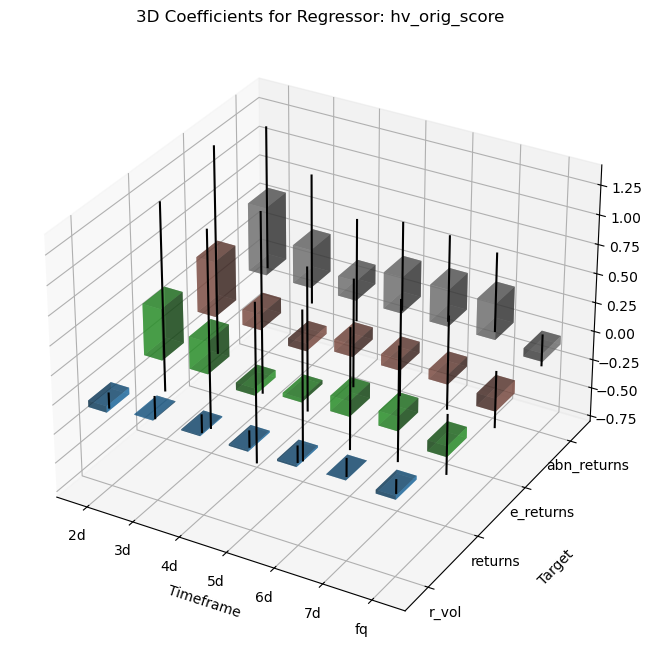

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


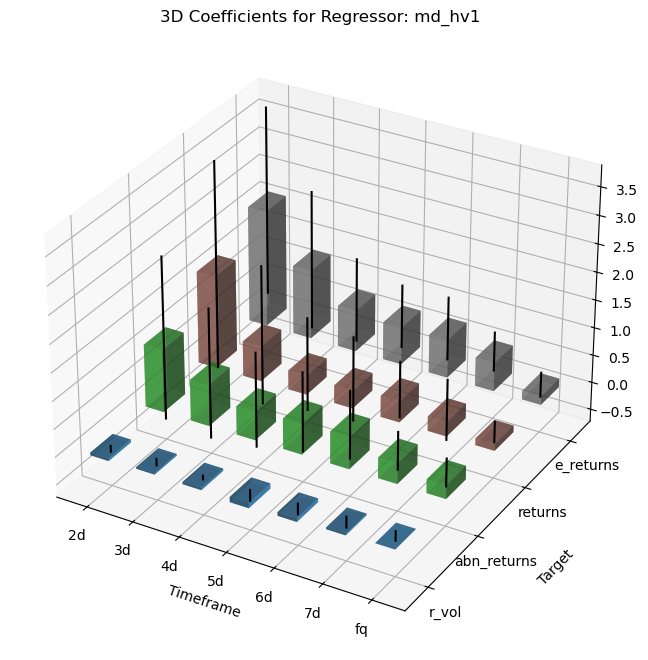

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


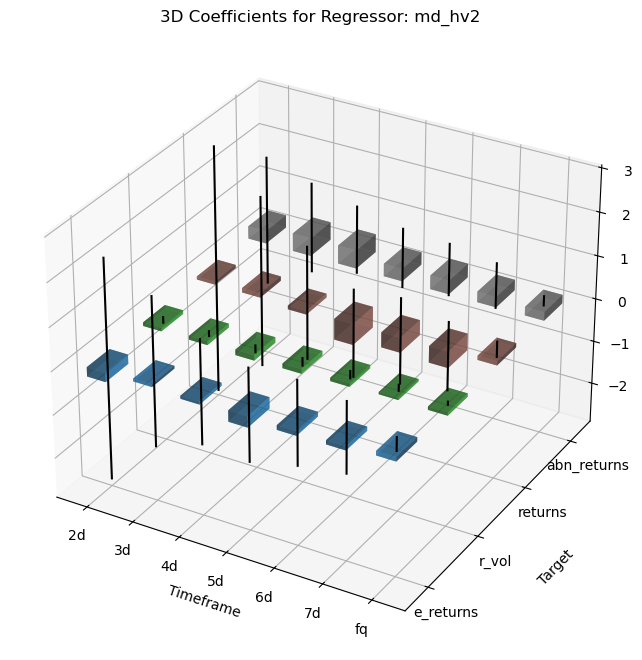

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


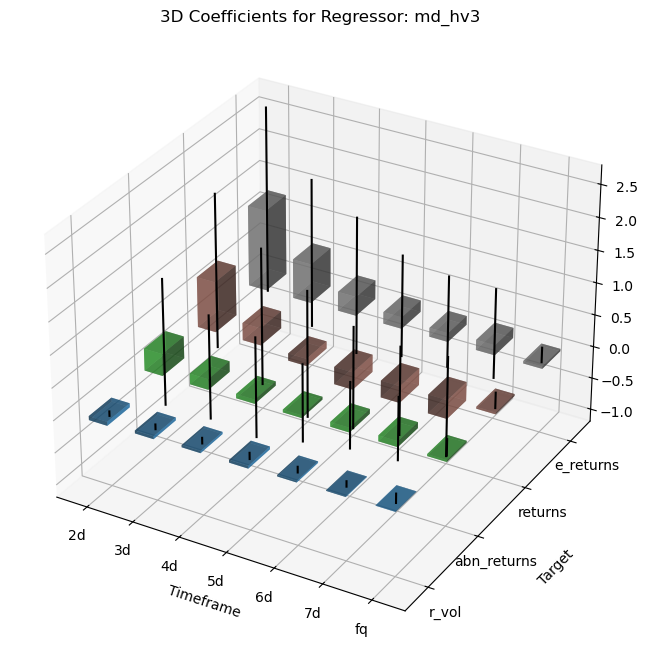

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


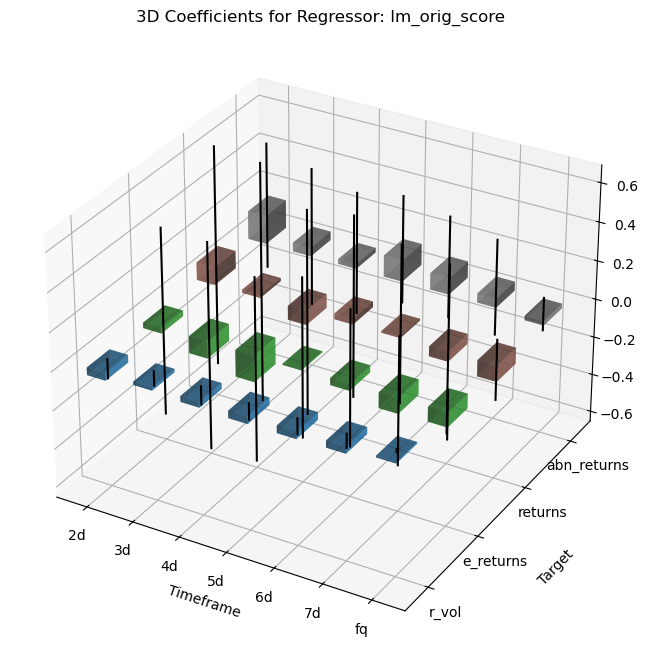

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


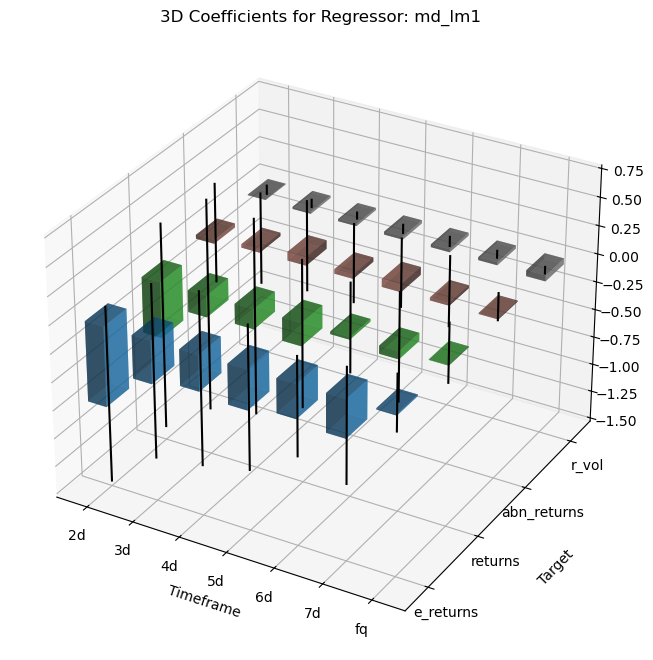

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


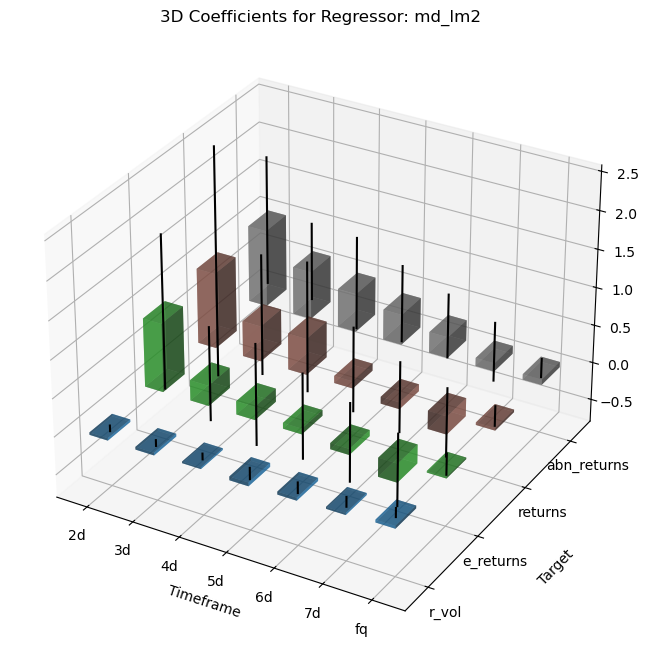

/tmp/ipykernel_33693/1388902710.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


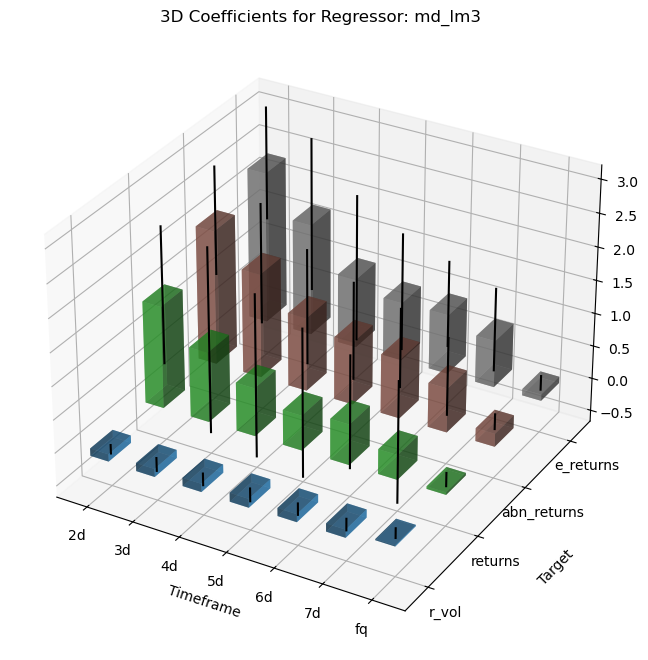

In [163]:
model.graph_3d()

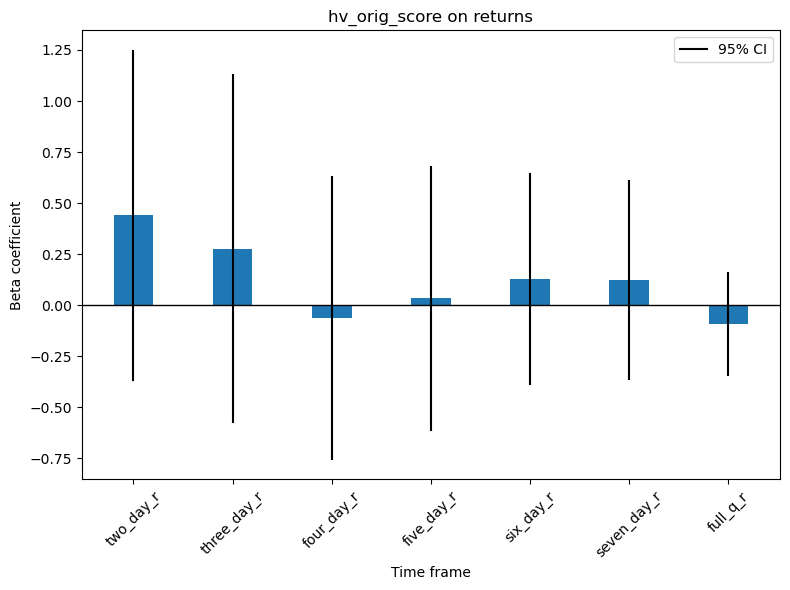

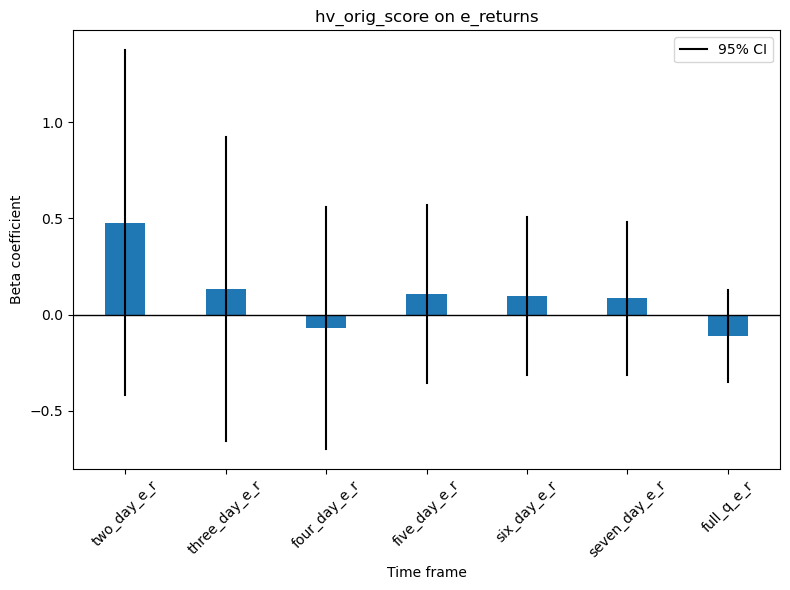

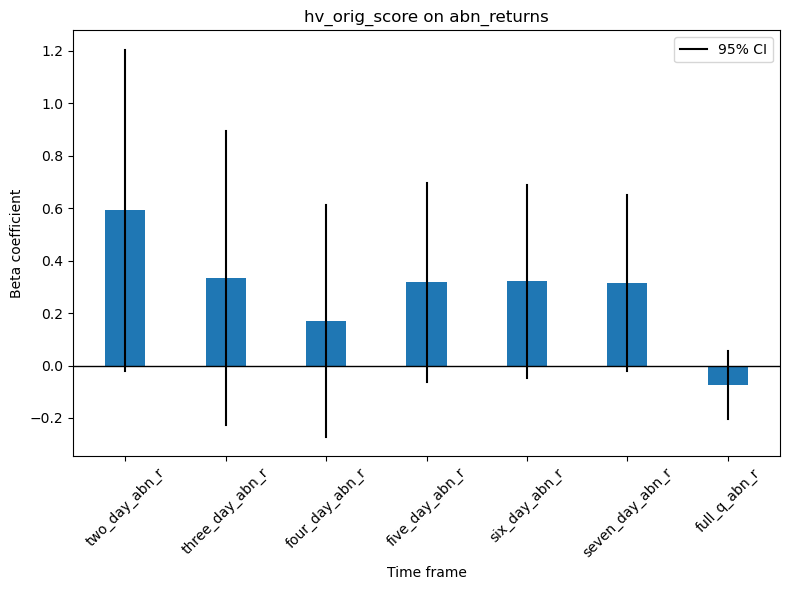

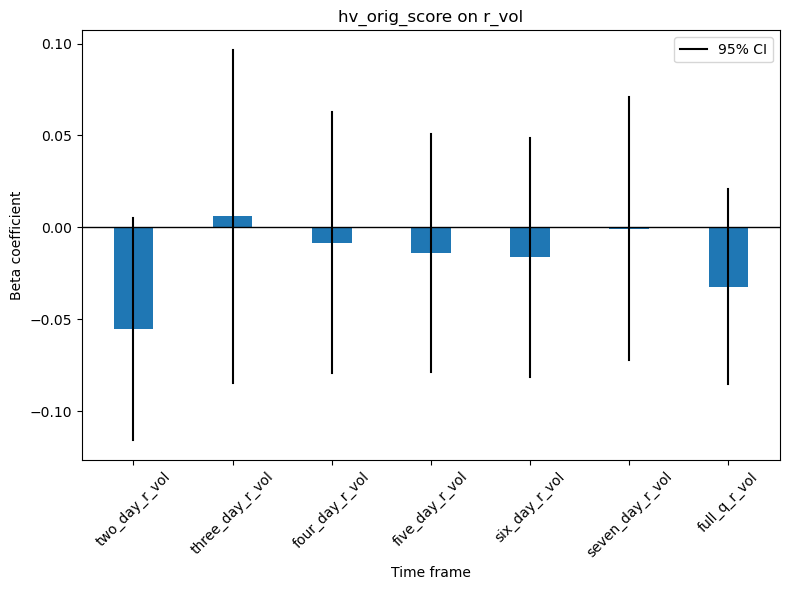

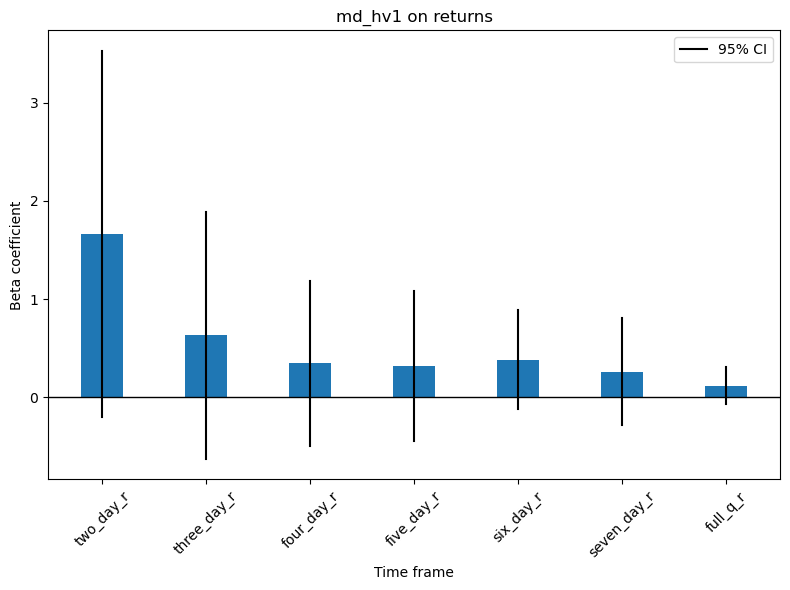

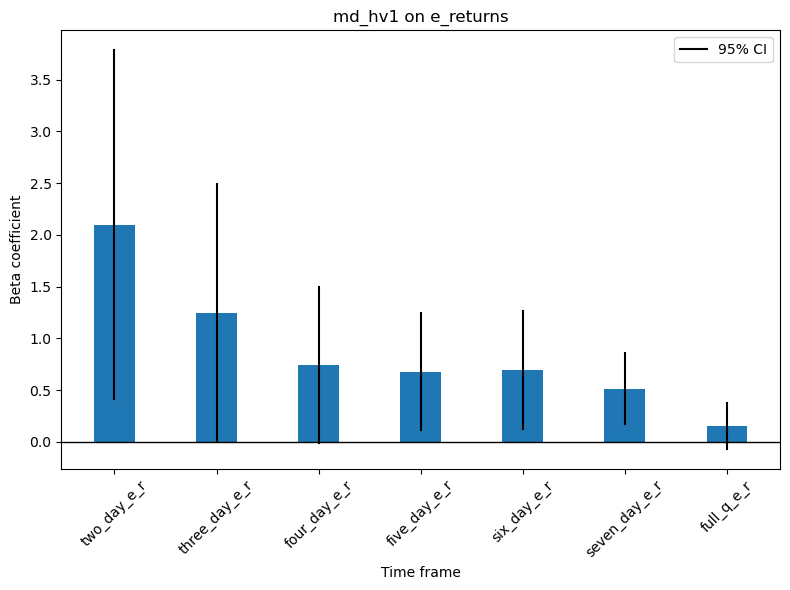

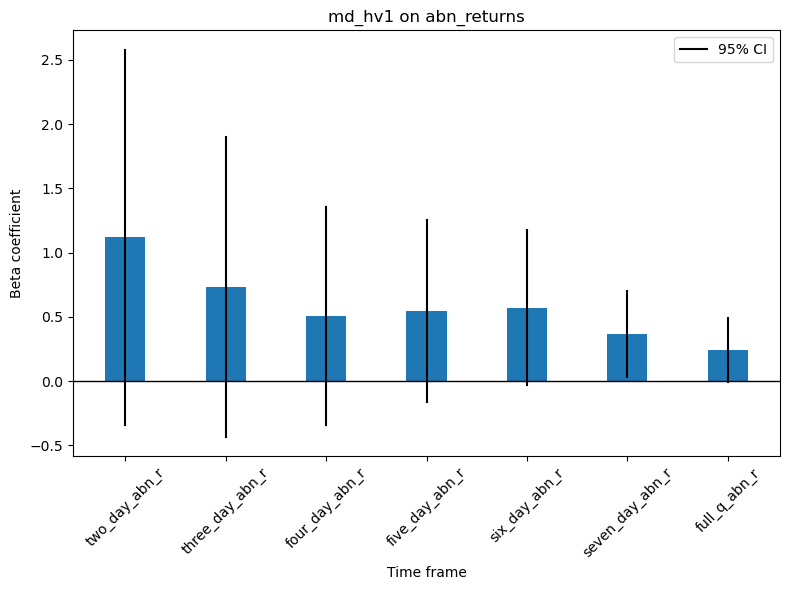

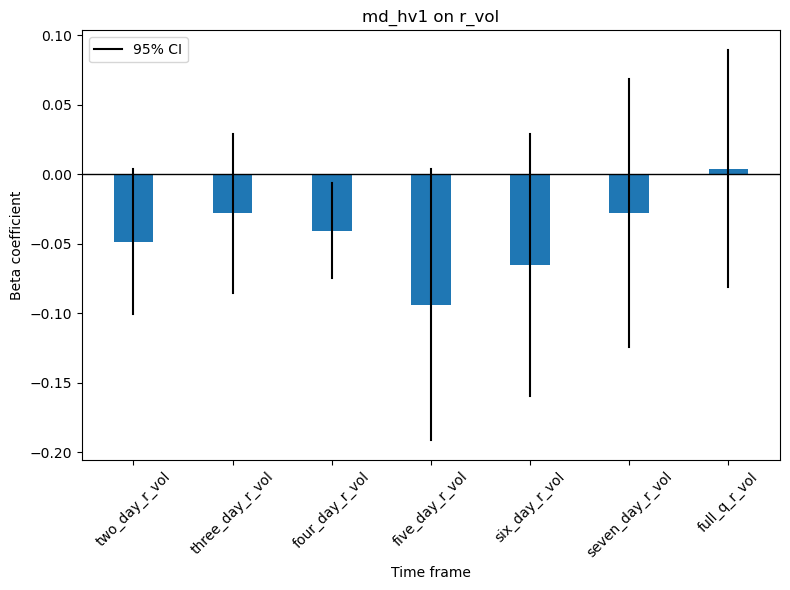

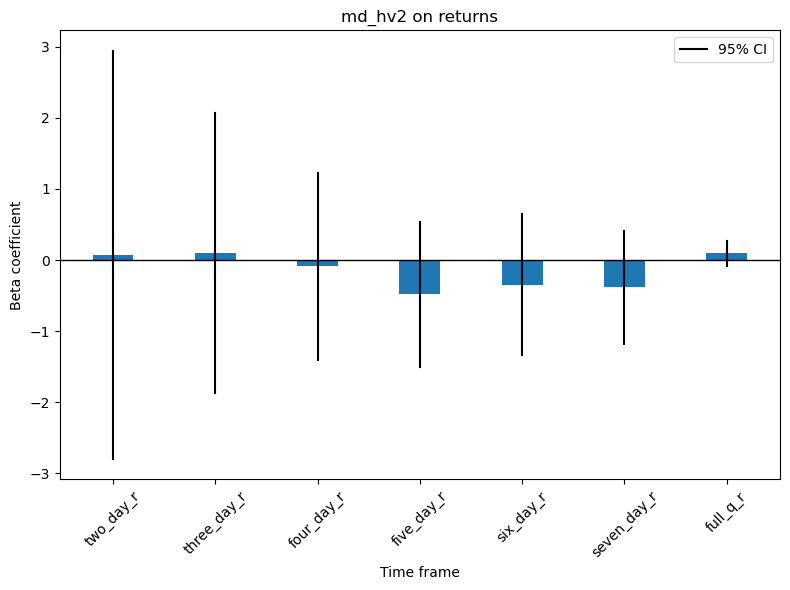

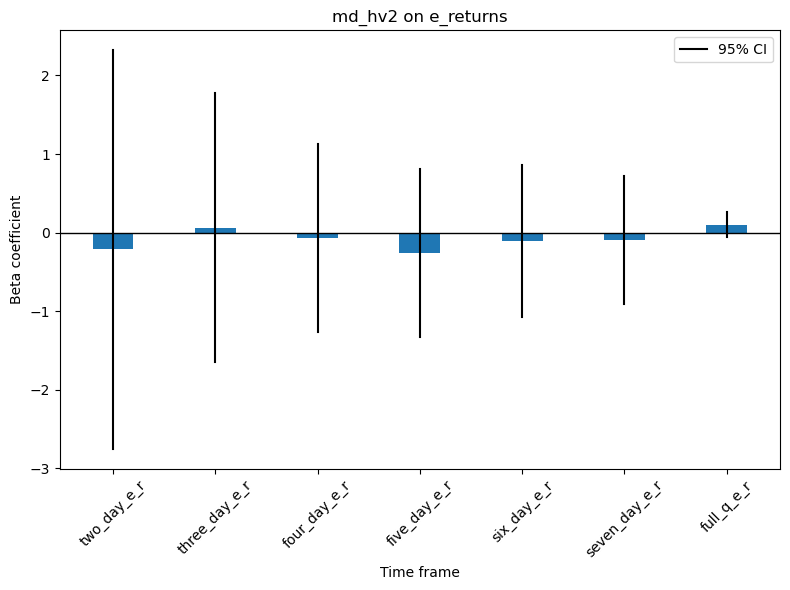

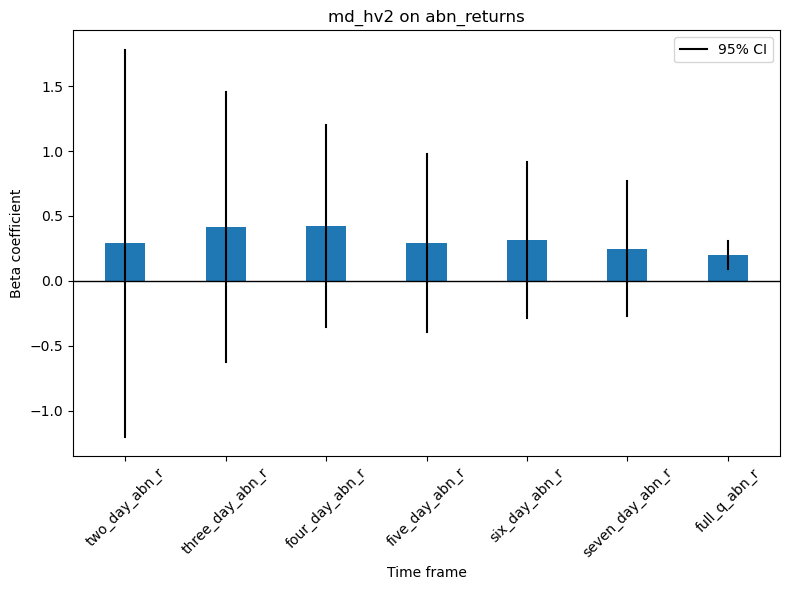

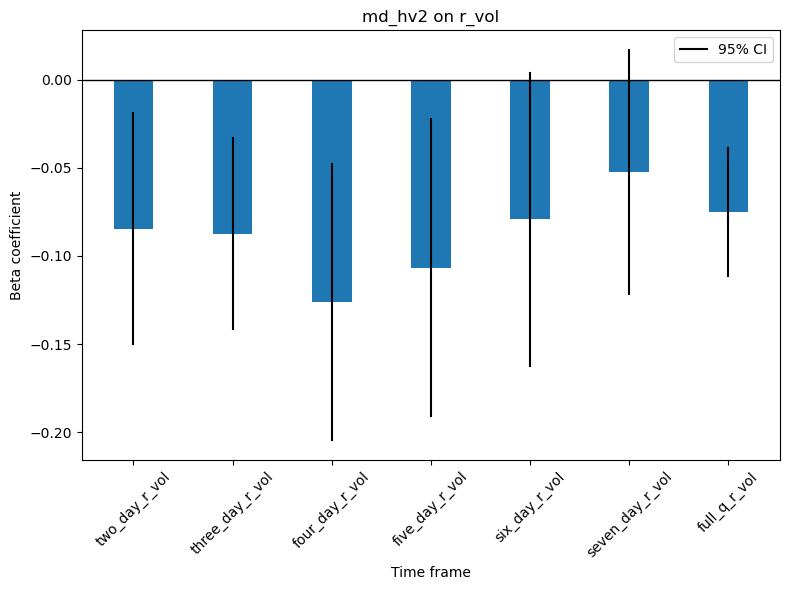

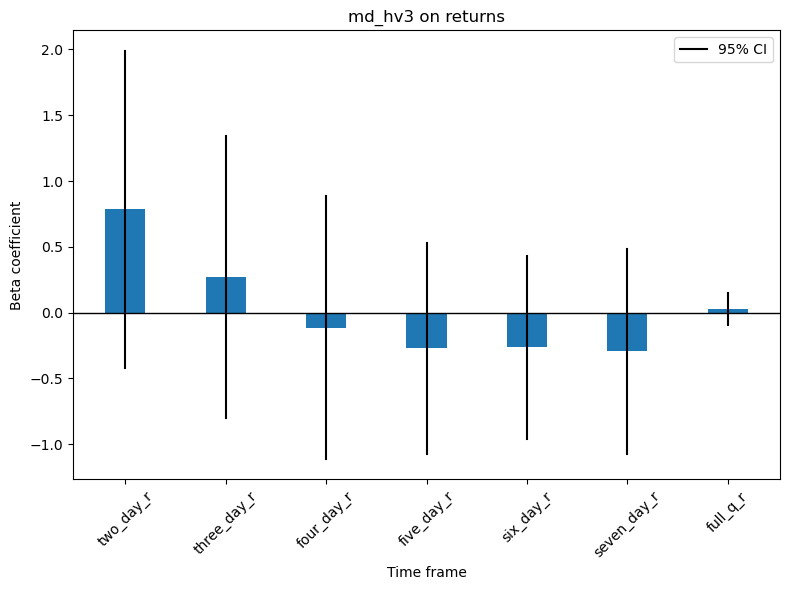

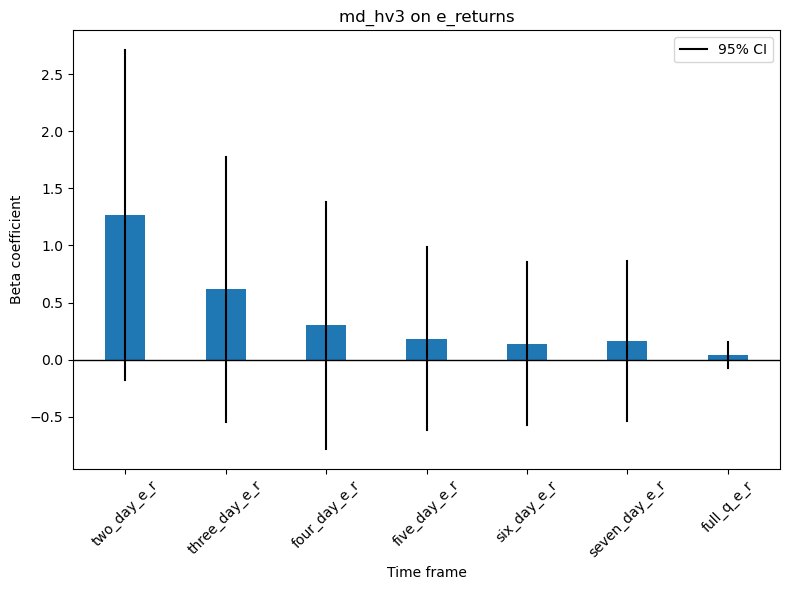

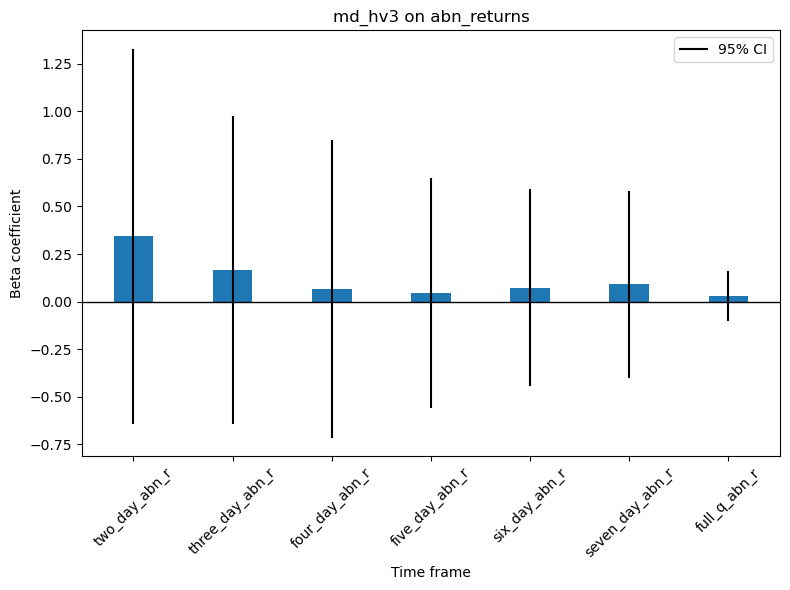

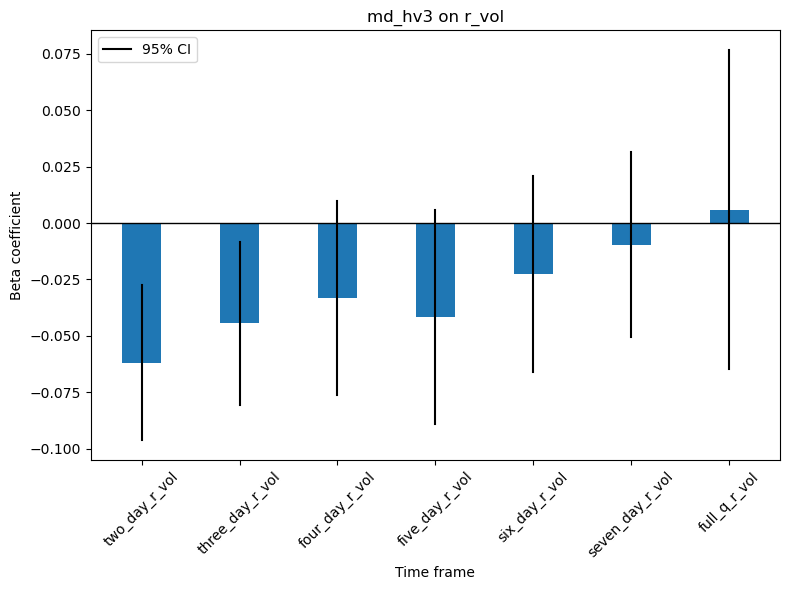

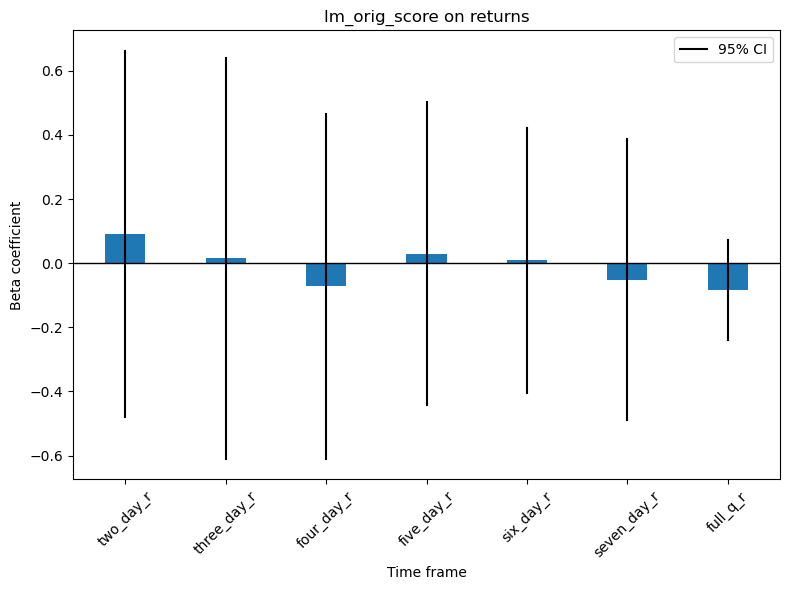

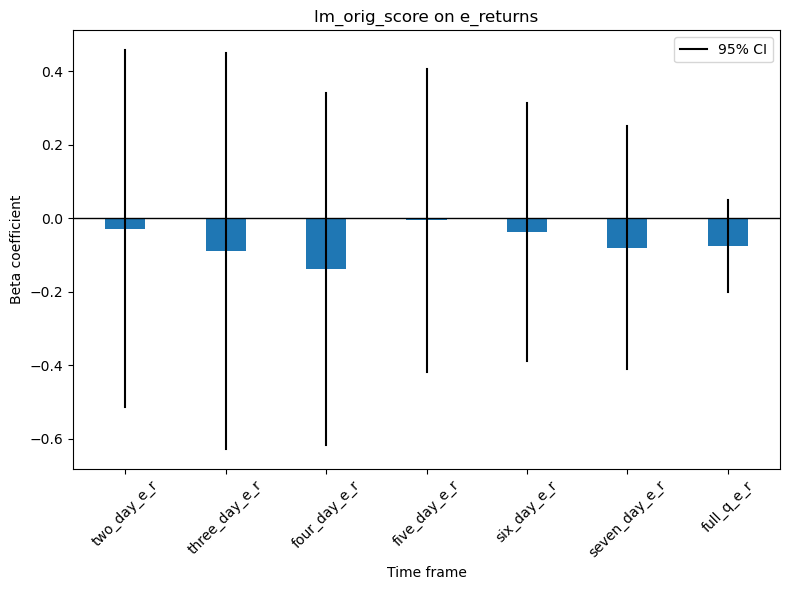

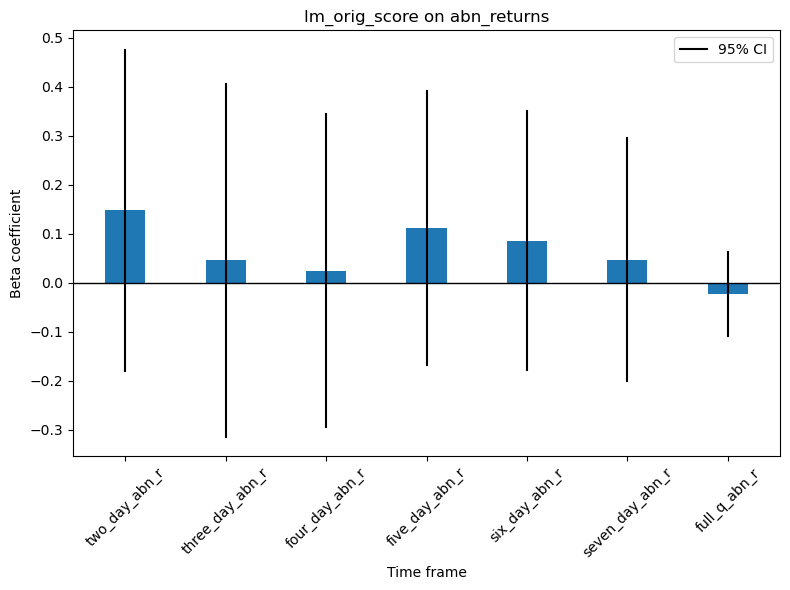

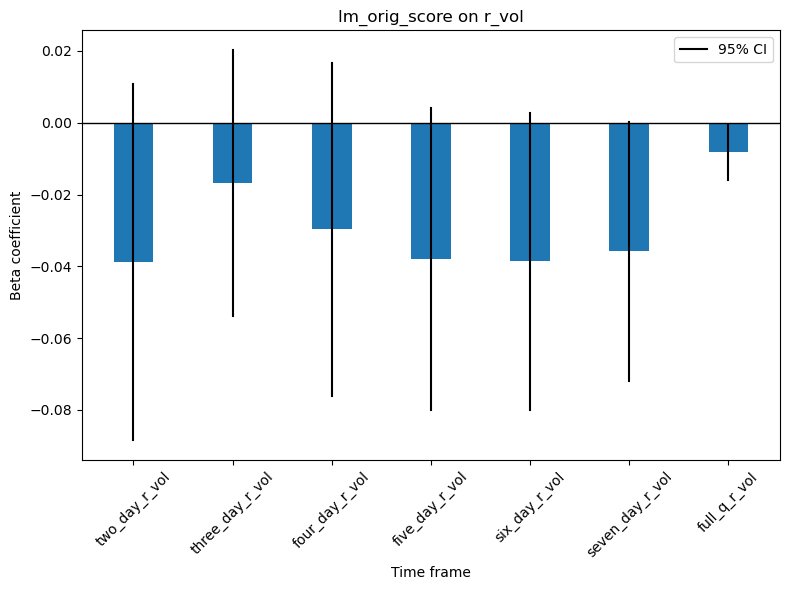

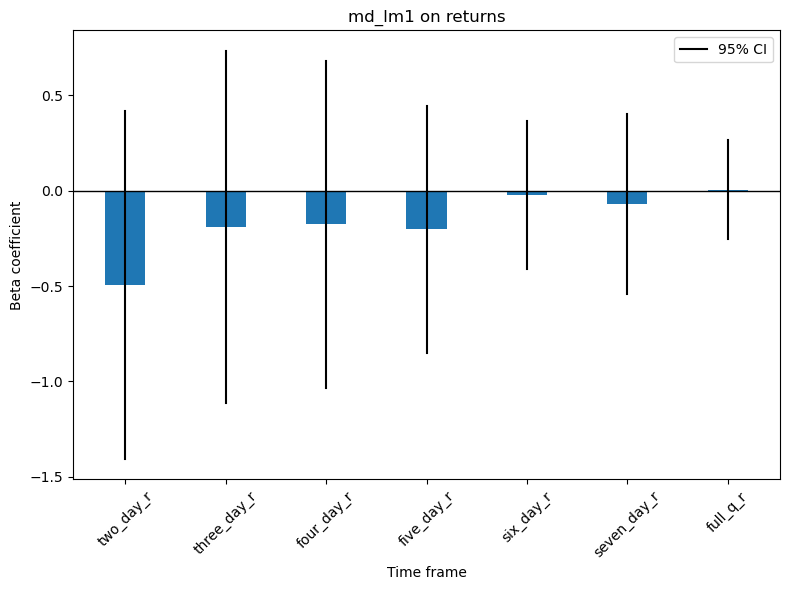

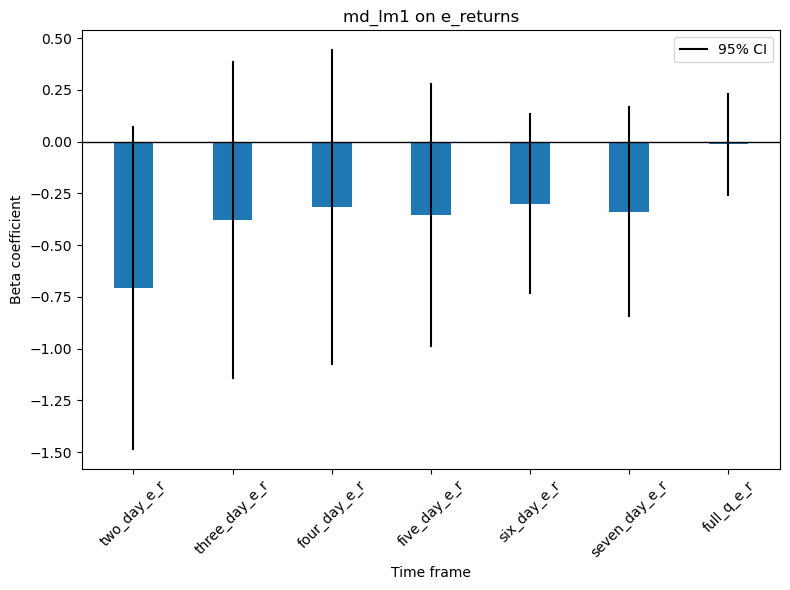

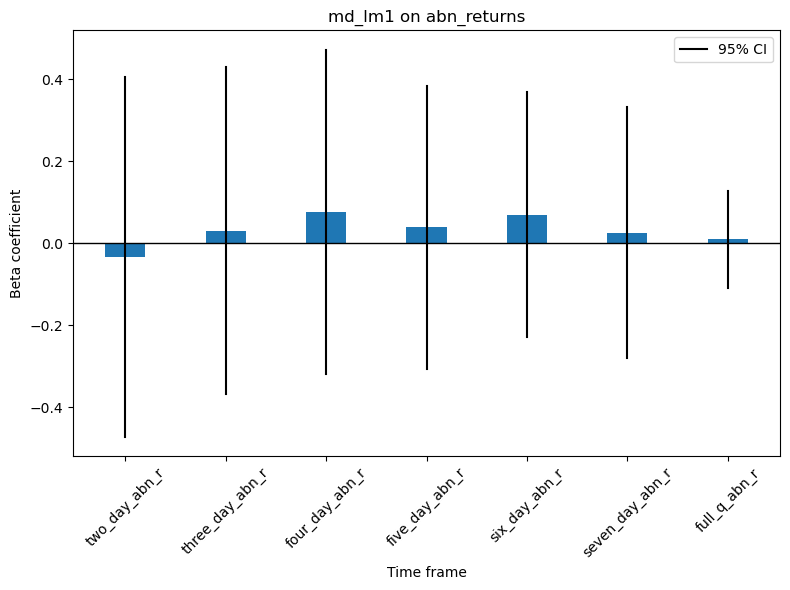

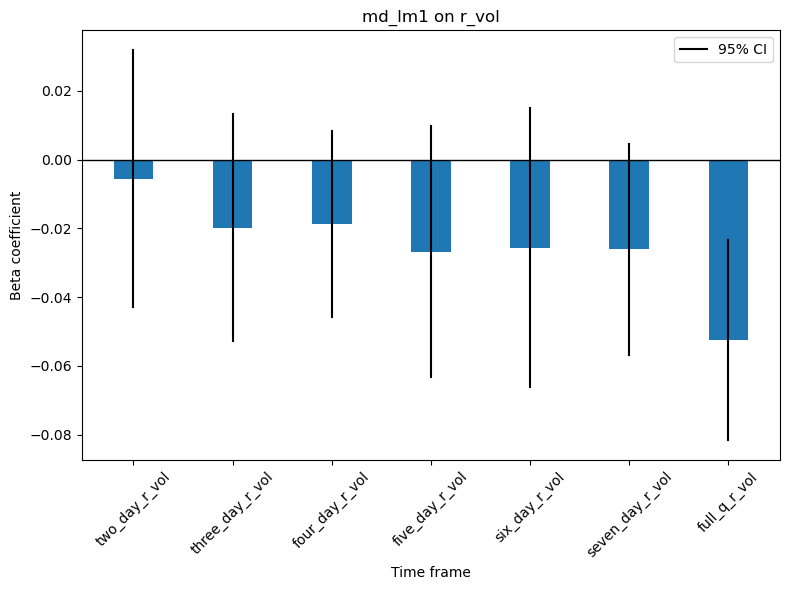

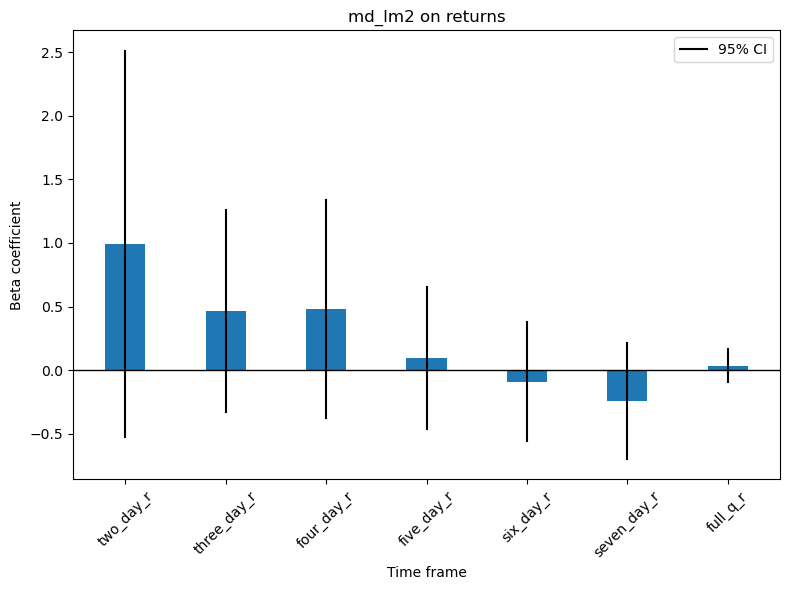

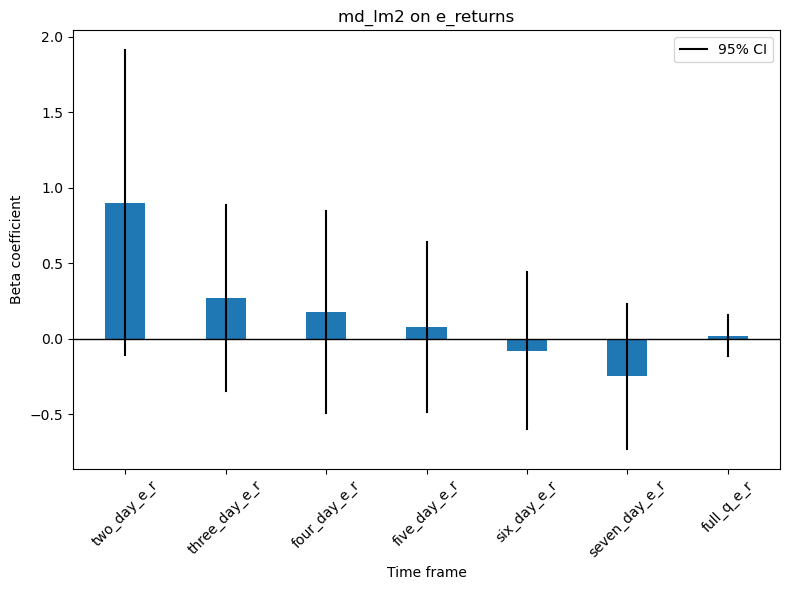

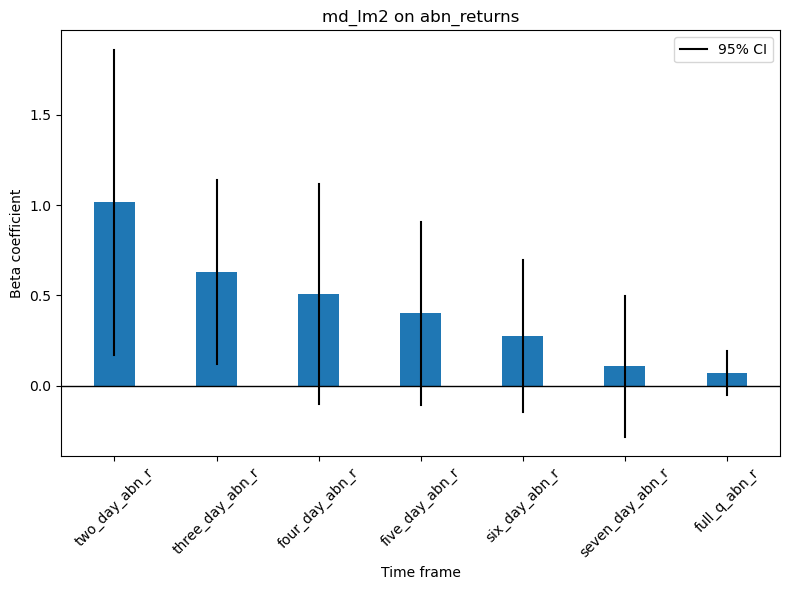

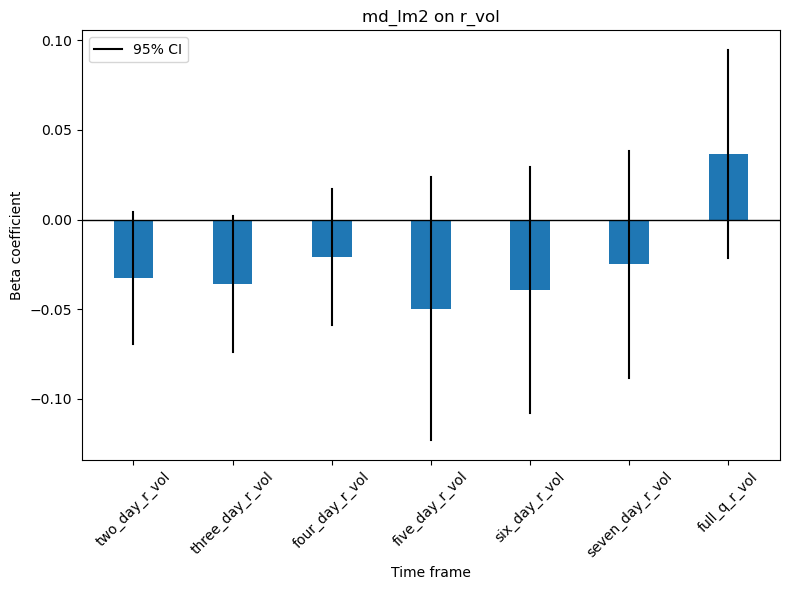

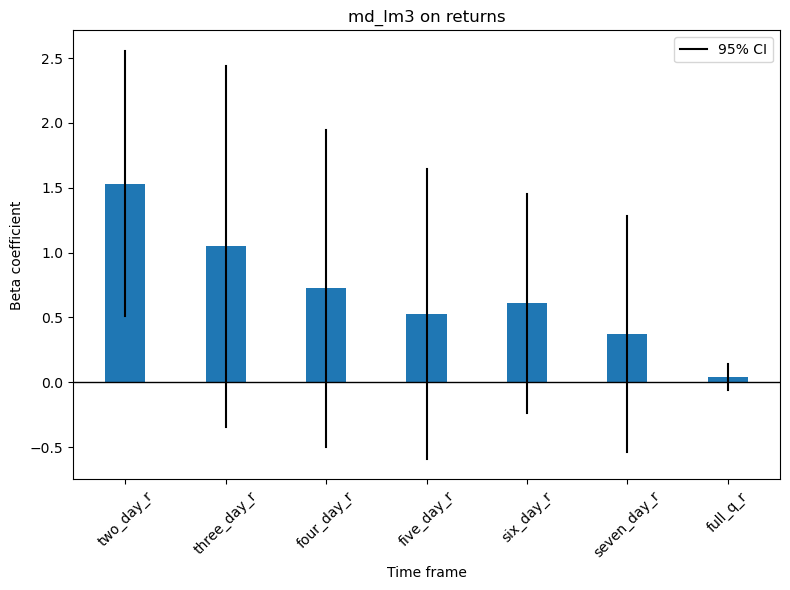

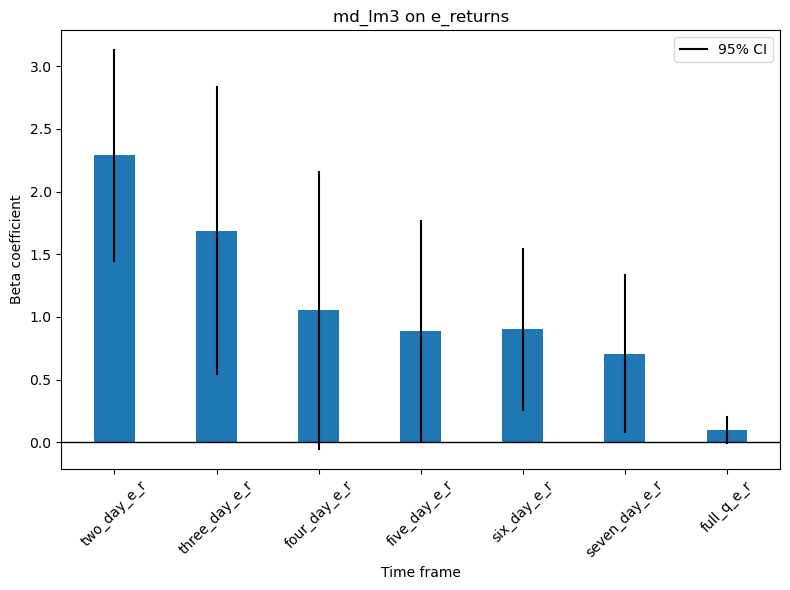

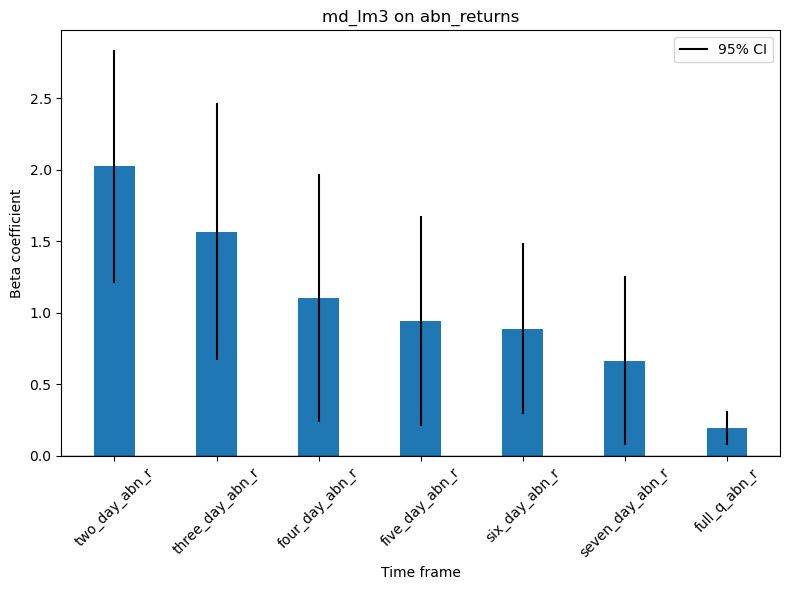

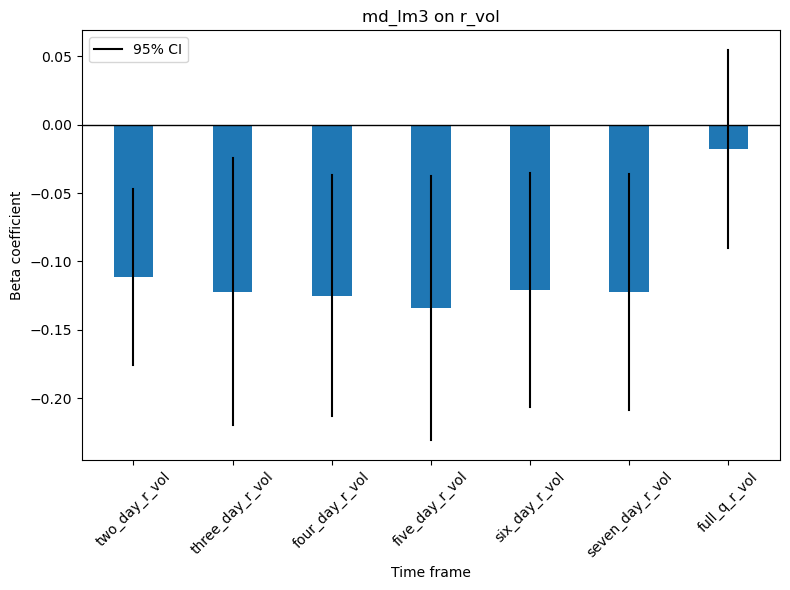

In [164]:
model.plot_all_params()